# Atelier ML - Reconnaissance de chiffres manuscrits

Dans cet atelier, vous allez entraîner un modèle qui permet de reconnaitre les chiffres écrits à la main à partir du dataset MNIST. Ensuite, vous pourrez intégrer ce modèle dans une application qui permettra à l'utilisateur de "dessiner" un chiffre et d'afficher la prédiction.

Etapes : 
*   Sélection d'un dataset restreint pour entraîner votre modèle
*   Gestion d'un dataset contenant des images en format pixel
*   Entrainement d'un modèle de Support Vector Machine (SVM)
*   Création d'un Pipeline
*   Sauvegarde d'un modèle avec Pickle
*   Création d'une application Streamlit avec une fonctionnalité de dessin (canva)
*   Prédictions directement dans l'application

In [1]:
# IMPORTS
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
from PIL import Image

Commencez par importer le dataset MNIST et comprendre son contenu.

Vous en savoir plus sur cette base de données : http://yann.lecun.com/exdb/mnist/ 

In [2]:
df = pd.read_csv('mnist.csv', sep=',')
print(df.shape)

(60000, 785)


In [5]:
df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Sous quelle forme se présentent vos données ? Que représentent-elles ?

In [ ]:
# 785 colonnes dont 1 colonne avec le label = chiffre représenté (0 à 9) et 784 colonnes avec les valeurs de pixels de 0 à 255 (matrice de 28x28).

Pour en savoir plus sur les valeurs du dataframe, <a href='https://www.whydomath.org/node/wavlets/imagebasics.html'> petite explication sur l'échelle des couleurs</a>.

Et en exécutant le code ci-dessous, vous y verrez déjà un peu plus clair 😋 

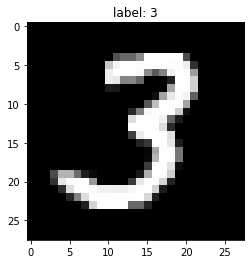

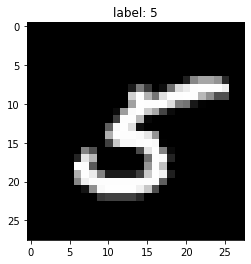

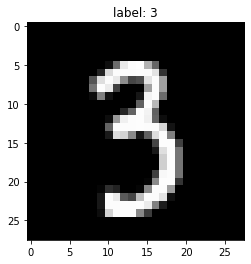

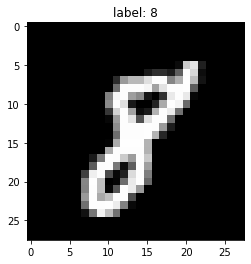

In [4]:
for i in (np.random.randint(0,270,4)):
    img_28_28 = np.array(df.iloc[i, 1:]).reshape(28,28)
    plt.title('label: {0}'. format(df.iloc[i, 0]))
    plt.imshow(img_28_28, interpolation='antialiased', cmap='gray')
    plt.show()

Ci-dessous une 2ème manière de visualiser le contenu d'une ligne de notre dataframe. Qu'obtenez-vous ?

In [5]:
for row in img_28_28:
    print(' '.join('{:3}'.format(value) for value in row))

  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  11 203 229  32   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  26  47  47  30  95 254 215  13   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0  45 154 185 185 223 253 253 133 175 255 188  19   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0 110 253 253 253 246 161 228 253 253 254  92   0   0   0   0 

Le site du MNIST donne plus d'informations sur le traitement mené sur les images d'origine pour qu'elles aient des formats comparables :

> The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28x28 field.

La description est technique mais permet de comprendre que les images qu'on va dessiner nous-mêmes vont également devoir passer par ce même traitement pour être comparables et donc bien prédites par notre modèle.

## Sélection des données

On a actuellement un dataframe avec 60 000 lignes. Comme vous allez entraîner des modèles, il est utile de réduire la quantité de données qu'on va utiliser ici. Cela risque de réduire la qualité de prédiction mais aussi le temps d'entraînement de nos modèles. Créez un dataframe plus léger en ne gardant que 10 000 lignes du dataframe initial.

Attention, pensez bien à avoir une représentation homogène de tous les labels que vous allez prédire (soit les chiffres de 0 à 9).

In [6]:
df_sample = pd.DataFrame()

for i in range(10):
    df_digit = df.loc[df['label'] == i].head(1000)
    df_sample = pd.concat([df_sample, df_digit], axis=0)

df_sample

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10142,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10143,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10165,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10166,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/Users/emilie/Desktop/projects/ATELIERS/Atelier Number Recognition/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


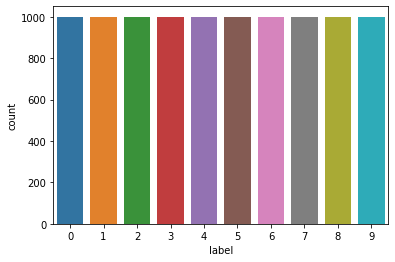

In [15]:
sns.countplot(df_sample['label'])
plt.show() # Comme souhaité, on a bien 1000 lignes pour chaque chiffre

## Machine Learning

Maintenant, c'est le moment de passer aux choses sérieuses ! On va préparer les données pour le Machine Learning. 

Après avoir défini vos variables explicatives et la variable cible, divisez vos données en jeux d'entraînement et de test.

In [7]:
from sklearn.model_selection import train_test_split

X = df_sample.iloc[:, 1:]
y = df_sample['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

Vérifiez la distribution des labels dans vos deux jeux (par ex. avec un <a href="https://seaborn.pydata.org/generated/seaborn.countplot.html">counplot</a>).

Les deux jeux ont-ils des distributions de classe similaires ? Sinon, avez-vous pensé à inclure un paramètre dans le train_test_split qui peut y remédier ? 

/Users/emilie/Desktop/projects/ATELIERS/Atelier Number Recognition/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


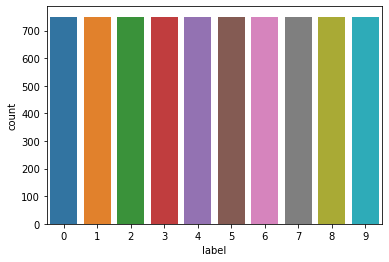

In [8]:
# Stratify s'applique bien, on a le même nombre de lignes par label/chiffre dans les deux jeux
sns.countplot(y_train)
plt.show()

#### Feature Scaling

Vous pouvez aussi standardiser vos données.

In [9]:
# Standardisation
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# Normalisation
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler()
X_train_mmscaled = minmax_scaler.fit_transform(X_train)
X_test_mmscaled = minmax_scaler.transform(X_test)

#### PCA

Pour améliorer nos performances et réduire le bruit dans nos données, on va réduire le nombre de variables utilisées pour notre ML en faisant une PCA. Faites plusieurs tests pour trouver un nombre de composants qui permet de garder une variance expliquée importante avec un bon score de précision tout en réduisant le temps d'entraînement.

In [11]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)
print(pca.explained_variance_ratio_)

[9.92936496e-02 7.07696480e-02 6.13722355e-02 5.47980393e-02
 4.80033040e-02 4.35762755e-02 3.28795320e-02 2.95782695e-02
 2.78276912e-02 2.33047835e-02 2.07748708e-02 2.04420132e-02
 1.72158417e-02 1.68881624e-02 1.62865135e-02 1.53632598e-02
 1.29908314e-02 1.27061897e-02 1.19874450e-02 1.14965088e-02
 1.05581559e-02 1.02111903e-02 9.59473522e-03 9.44274096e-03
 8.76175351e-03 8.24666545e-03 7.97672298e-03 7.80483870e-03
 7.20926106e-03 6.88048168e-03 6.57692685e-03 6.40872821e-03
 6.06378996e-03 5.89225299e-03 5.68707203e-03 5.32941139e-03
 5.10196389e-03 4.86306346e-03 4.81660539e-03 4.72430454e-03
 4.54020432e-03 4.20308654e-03 4.15719040e-03 4.07336269e-03
 3.78319566e-03 3.61275365e-03 3.54014498e-03 3.47080496e-03
 3.29861021e-03 3.25956844e-03 3.20461259e-03 3.15826001e-03
 3.01661172e-03 2.89853025e-03 2.82110529e-03 2.73953898e-03
 2.67345170e-03 2.56724769e-03 2.49436866e-03 2.47683511e-03
 2.41130722e-03 2.37070113e-03 2.24961275e-03 2.20140365e-03
 2.11476856e-03 2.063657

In [24]:
len(pca.explained_variance_ratio_)

784

In [25]:
# PCA with 90% of variance explained
pca_90 = PCA(n_components=.9)
pca_90.fit(X_train)
print(pca_90.explained_variance_ratio_)

[0.09929365 0.07076965 0.06137224 0.05479804 0.0480033  0.04357628
 0.03287953 0.02957827 0.02782769 0.02330478 0.02077487 0.02044201
 0.01721584 0.01688816 0.01628651 0.01536326 0.01299083 0.01270619
 0.01198745 0.01149651 0.01055816 0.01021119 0.00959474 0.00944274
 0.00876175 0.00824667 0.00797672 0.00780484 0.00720926 0.00688048
 0.00657693 0.00640873 0.00606379 0.00589225 0.00568707 0.00532941
 0.00510196 0.00486306 0.00481661 0.0047243  0.0045402  0.00420309
 0.00415719 0.00407336 0.0037832  0.00361275 0.00354014 0.0034708
 0.00329861 0.00325957 0.00320461 0.00315826 0.00301661 0.00289853
 0.00282111 0.00273954 0.00267345 0.00256725 0.00249437 0.00247684
 0.00241131 0.0023707  0.00224961 0.0022014  0.00211477 0.00206366
 0.00202066 0.00196218 0.00192081 0.00189354 0.00183605 0.00175825
 0.00172954 0.00169552 0.0016731  0.0016052  0.0015795  0.00154283
 0.00145389 0.00142593 0.0014131  0.00139264 0.00137008 0.00133201
 0.00131781]


In [26]:
len(pca_90.explained_variance_ratio_)

85

In [40]:
X_train_reduced = pca_90.fit_transform(X_train)
X_test_reduced = pca_90.transform(X_test)

In [12]:
# PCA with 80% of variance explained
pca_80 = PCA(n_components=.8)
pca_80.fit(X_train)
print(pca_80.explained_variance_ratio_)

[0.09929365 0.07076965 0.06137224 0.05479804 0.0480033  0.04357628
 0.03287953 0.02957827 0.02782769 0.02330478 0.02077487 0.02044201
 0.01721584 0.01688816 0.01628651 0.01536326 0.01299083 0.01270619
 0.01198745 0.01149651 0.01055816 0.01021119 0.00959474 0.00944274
 0.00876175 0.00824667 0.00797672 0.00780484 0.00720926 0.00688048
 0.00657693 0.00640873 0.00606379 0.00589225 0.00568707 0.00532941
 0.00510196 0.00486306 0.00481661 0.0047243  0.0045402  0.00420309
 0.00415719]


In [13]:
len(pca_80.explained_variance_ratio_)

43

In [14]:
X_train_reduced_80 = pca_80.fit_transform(X_train)
X_test_reduced_80 = pca_80.transform(X_test)

In [35]:
# standardisation + PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_reduced = pca_80.fit_transform(X_train_scaled)
X_test_scaled_reduced = pca_80.transform(X_test_scaled)

In [ ]:
pca_90 = PCA(n_components=.9)
pca_90.fit(X_train)
print(pca_90.explained_variance_ratio_)

[0.09929365 0.07076965 0.06137224 0.05479804 0.0480033  0.04357628
 0.03287953 0.02957827 0.02782769 0.02330478 0.02077487 0.02044201
 0.01721584 0.01688816 0.01628651 0.01536326 0.01299083 0.01270619
 0.01198745 0.01149651 0.01055816 0.01021119 0.00959474 0.00944274
 0.00876175 0.00824667 0.00797672 0.00780484 0.00720926 0.00688048
 0.00657693 0.00640873 0.00606379 0.00589225 0.00568707 0.00532941
 0.00510196 0.00486306 0.00481661 0.0047243  0.0045402  0.00420309
 0.00415719 0.00407336 0.0037832  0.00361275 0.00354014 0.0034708
 0.00329861 0.00325957 0.00320461 0.00315826 0.00301661 0.00289853
 0.00282111 0.00273954 0.00267345 0.00256725 0.00249437 0.00247684
 0.00241131 0.0023707  0.00224961 0.0022014  0.00211477 0.00206366
 0.00202066 0.00196218 0.00192081 0.00189354 0.00183605 0.00175825
 0.00172954 0.00169552 0.0016731  0.0016052  0.0015795  0.00154283
 0.00145389 0.00142593 0.0014131  0.00139264 0.00137008 0.00133201
 0.00131781]


In [37]:
# standardisation + PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_reduced = pca_90.fit_transform(X_train_scaled)
X_test_scaled_reduced = pca_90.transform(X_test_scaled)

### SVM

Super ! Vos données sont prêtes. Vous allez entraîner un modèle de Support Vector Machine (SVM). 🤖

Pour séparer les classes, ce modèle génère un hyperplan dans un espace à N-dimensions (autant de dimensions que vous avez de variables explicatives) en maximisant l'espace entre l'hyperplan et les support vecteurs (soit les coordonnées des points).



<img src="https://miro.medium.com/max/1400/1*ZpkLQf2FNfzfH4HXeMw4MQ.png" />


Quelques ressources pour en apprendre plus sur le SVM : 
*   https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/ 
*   https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47 
*   Le modèle est disponible dans <a href="https://scikit-learn.org/stable/modules/svm.html">sklearn</a>.


Entraînez un modèle en testant plusieurs hyperparamètres (par ex. "kernel" pour SVM ou "n_components" pour la PCA). <a href="https://towardsdatascience.com/how-to-select-the-best-number-of-principal-components-for-the-dataset-287e64b14c6d"> Ici un article utile</a> sur la manière dont on peut choisir le nombre de composantes.

Et pourquoi ne pas réaliser une GridSearch pour trouver les meilleurs paramètres ?

In [29]:
# pas de pré-traitement sur les données
from sklearn.svm import SVC

svm = SVC(kernel='rbf', probability=False)
svm.fit(X_train, y_train)

print(svm.score(X_train, y_train))
print(svm.score(X_test, y_test))

0.9857333333333334
0.9552


In [36]:
# après standardisation
from sklearn.svm import SVC

svm = SVC(kernel='rbf', probability=False)
svm.fit(X_train_scaled, y_train)

print(svm.score(X_train_scaled, y_train))
print(svm.score(X_test_scaled, y_test))

0.9806666666666667
0.944


In [32]:
# après normalisation
from sklearn.svm import SVC

svm = SVC(kernel='rbf', probability=False)
svm.fit(X_train_mmscaled, y_train)

print(svm.score(X_train_mmscaled, y_train))
print(svm.score(X_test_mmscaled, y_test))

0.9857333333333334
0.9544


In [69]:
# avec PCA, 0.90 + rbf
from sklearn.svm import SVC

svm = SVC(kernel='rbf', probability=False)
svm.fit(X_train_reduced, y_train)

print(svm.score(X_train_reduced, y_train))
print(svm.score(X_test_reduced, y_test))

0.9905333333333334
0.9656


In [ ]:
# avec PCA, 0.8
from sklearn.svm import SVC

svm = SVC(kernel='rbf', probability=False)
svm.fit(X_train_reduced_80, y_train)

print(svm.score(X_train_reduced_80, y_train))
print(svm.score(X_test_reduced_80, y_test))

0.9872
0.9636


In [ ]:
# avec PCA, 0.90 + linear
from sklearn.svm import SVC

svm = SVC(kernel='linear', probability=False)
svm.fit(X_train_reduced, y_train)

print(svm.score(X_train_reduced, y_train))
print(svm.score(X_test_reduced, y_test))

In [38]:
# après standardisation avec PCA 0.9
from sklearn.svm import SVC

svm = SVC(kernel='rbf', probability=False)
svm.fit(X_train_scaled_reduced, y_train)

print(svm.score(X_train_scaled_reduced, y_train))
print(svm.score(X_test_scaled_reduced, y_test))

0.9817333333333333
0.94


In [41]:
# après standardisation avec PCA 0.8
from sklearn.svm import SVC

svm = SVC(kernel='rbf', probability=False)
svm.fit(X_train_scaled_reduced, y_train)

print(svm.score(X_train_scaled_reduced, y_train))
print(svm.score(X_test_scaled_reduced, y_test))

0.9806666666666667
0.944


In [11]:
#svm = SVC(kernel='poly')
#svm.fit(X_train, y_train)

#print(svm.score(X_train, y_train))
#print(svm.score(X_test, y_test))

0.9870666666666666
0.9472


In [ ]:
# On obtient un des meilleurs scores avec l'hyper-paramètre RBF et une PCA où on garde 43 variables explicatives (pour 80% de la variance).
# On choisit donc ce modèle.
# Il est surprenant ici de voir que la standardisation et la normalisation réduisent légèrement les scores sur les jeux de tests.

Une fois le meilleur modèle identifié, vous pouvez le ré-entrainer en incluant le paramètre `probability=True` : ce paramètre permet d'avoir les probabilités de chaque classe dans les prédictions, ce qui sera utile dans la suite de notre travail.
 
Créez une variable `y_pred` avec les prédictions sur votre jeu de test.

In [15]:
# Modèle sélectionné : PCA 0.8 et kernel rbf
from sklearn.svm import SVC

svm = SVC(kernel='rbf', probability=True)
svm.fit(X_train_reduced_80, y_train)

print(svm.score(X_train_reduced_80, y_train))
print(svm.score(X_test_reduced_80, y_test))

0.9872
0.9636


In [16]:
y_pred = svm.predict(X_test_reduced_80)

Maintenant que vous avez entrainé votre modèle, on va le tester en pratique sur les images.

Comme au début, on peut afficher plusieurs images de notre jeu de test avec la prédiction faite par notre modèle. Attention, il faut bien distinguer le `X_test` initial qui contient les 748 champs avec les valeurs des pixels, et notre `X_test` transformé après la PCA dont on ne peux plus distinguer les composantes (le code ci-dessous ne fonctionnera que si vous n'avez pas modifié le `X_test` initial mais créé une nouvelle variable en faisant la PCA).

In [24]:
X_test

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
1768,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3708,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1981,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9555,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7471,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7049,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
974,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5194,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5299,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
X_test_reduced_80

array([[ 972.35409311,  253.08060153, -498.23969058, ...,   53.28437814,
         -52.43861527,    6.2144566 ],
       [-295.72456582,  738.70833736, -416.12899903, ...,  -53.33920144,
         -97.81118043,  151.72287203],
       [ 491.6703686 , -554.07412462,  131.31396024, ...,  246.68406889,
         -27.32932104,  -60.47936764],
       ...,
       [ 700.73685891,  301.77496113,  108.89399986, ...,  219.30465413,
         110.93859789,  295.81319426],
       [ -57.21925088, -287.96278511,  723.63286358, ...,   73.17087558,
         -65.65262341,  179.07604991],
       [ 132.25946893,  977.04006765,   51.08542398, ...,  -76.3822992 ,
         -47.43832368, -101.67625144]])

In [19]:
svm.predict(X_test_reduced_80)[1]

4

In [20]:
svm.predict_proba(X_test_reduced_80)[1]

array([6.47091644e-05, 8.99959854e-05, 9.24243671e-05, 3.54960732e-04,
       9.97210415e-01, 5.46317040e-05, 5.62814419e-05, 1.62471170e-03,
       5.74129192e-05, 3.94456526e-04])

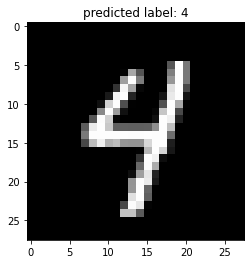

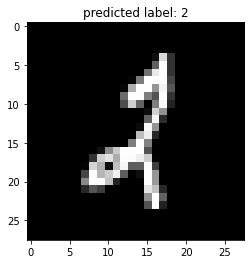

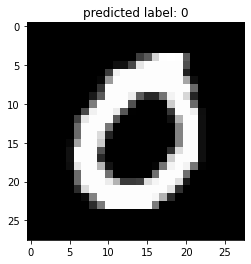

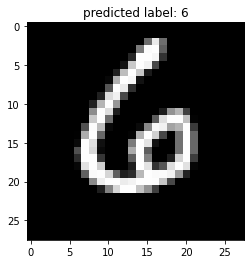

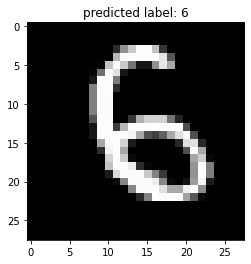

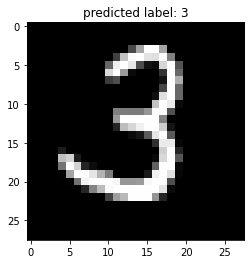

In [28]:
for i in (np.random.randint(0,270,6)):
    two_d = (np.reshape(X_test.values[i], (28, 28))).astype(np.uint8)
    plt.title('predicted label: {0}'. format(y_pred[i]))
    plt.imshow(two_d, interpolation='antialiased', cmap='gray')
    plt.show()

Affichez une matrice de confusion. Les résultats vous semblent-ils satisfaisants ?

In [29]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[248,   0,   0,   0,   1,   0,   0,   0,   0,   1],
       [  0, 247,   1,   1,   0,   0,   0,   0,   0,   1],
       [  0,   0, 242,   2,   3,   0,   1,   0,   2,   0],
       [  0,   1,   4, 228,   1,   7,   0,   6,   2,   1],
       [  0,   0,   1,   0, 242,   0,   0,   1,   0,   6],
       [  0,   0,   0,   5,   1, 241,   3,   0,   0,   0],
       [  2,   0,   0,   1,   0,   0, 246,   0,   1,   0],
       [  2,   0,   1,   0,   3,   0,   0, 244,   0,   0],
       [  0,   2,   1,   3,   1,   1,   2,   0, 239,   1],
       [  1,   1,   1,   5,   4,   0,   0,   5,   1, 232]])

Le modèle devrait donner des résultats satisfaisants dans l'ensemble.

## Création d'une pipeline

Examinez le code ci-dessous puis exécutez-le. 

In [30]:
from sklearn.model_selection import train_test_split

X = df_sample.iloc[:, 1:]
y = df_sample['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC

steps = [('pca', PCA(n_components=.8)), ('svm', SVC(kernel='rbf', probability=True))]
pipeline = Pipeline(steps)    

In [32]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=0.8)), ('svm', SVC(probability=True))])

In [33]:
pipeline.predict(X_test)

array([6, 4, 3, ..., 0, 8, 4])

In [34]:
print(pipeline.score(X_train, y_train))
print(pipeline.score(X_test, y_test))

0.9872
0.9636


On crée ici un Pipeline, il s'agit d'une suite d'actions qui permet en une seule exécution de réaliser plusieurs traitements à la suite sur nos données. 

Ce pipeline reprend ce qu'on a fait plus haut, à savoir il applique la PCA puis le modèle SVM sur nos données. Si vous avez standardisé vos données, vous pouvez ajouter cette étape dans le pipeline. 

Un pipeline peut aussi être utilisé pour tester divers hyperparamètres sur plusieurs étapes d'entraînement du modèle (par ex. n_components dans la PCA, hyperparamètres du modèle) : un exemple concret <a href="https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html"> ici</a>.

## Sauvegarde du modèle

Pour pouvoir rapidement prédire un label sur de nouvelles données (soit des chiffres qu'on va dessiner nous-mêmes !), il est utile de stocker notre modèle entraîné dans un fichier à partir duquel on pourra directement le charger dans notre application. 

Pour cela, on utilise la librairie Pickle qui permet de 'sérialiser' et de 'désérialiser' des objets Python, c'est-à-dire de stocker dans un format binaire le contenu d'un objet (une liste, un modèle...) qu'on peut ré-importer ensuite.

*   Documentation Python sur Pickle (FR) : https://docs.python.org/fr/3/library/pickle.html
*   https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
*   https://www.quennec.fr/trucs-astuces/langages/python/python-le-module-pickle 

In [35]:
import pickle
filename = 'digit_classifier.sav'

In [36]:
# Save the model
pickle.dump(pipeline, open(filename, 'wb'))

Après l'exécution de ce code, vous devriez avoir un nouveau fichier `digit_classifier.sav` qui stocke votre modèle.

In [37]:
 # Load the model
loaded_model = pickle.load(open(filename, 'rb'))

In [38]:
loaded_model

Pipeline(steps=[('pca', PCA(n_components=0.8)), ('svm', SVC(probability=True))])

## Test des prédictions

On teste notre modèle enregistré sur une des prédictions (1e ligne de X_test).

In [39]:
# On a 784 colonnes correspondant aux 28x28 pixels de l'image
img_test_0 = X_test.iloc[0].values
img_test_0.shape

(784,)

In [40]:
# On ajoute une dimension pour la prédiction
img_test_0 =  np.array(img_test_0).reshape(1, -1) 
img_test_0.shape

(1, 784)

Affichez la valeur prédite pour la 1ère ligne de X_test.

In [42]:
# Le modèle prédit un 6 pour la 1e ligne de X_test
loaded_model.predict(img_test_0)

/Users/emilie/Desktop/projects/ATELIERS/Atelier Number Recognition/venv/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


array([6])

In [43]:
# On change les dimensions de la 1e ligne pour obtenir une matrice de 28x28
img_test_0 = img_test_0.reshape(28, 28)
img_test_0.shape

(28, 28)

On peut ainsi afficher la matrice au format 28x28. Le chiffre prédit apparait-il bien dans cette matrice ?


In [44]:
for row in img_test_0:
    print(' '.join('{:3}'.format(value) for value in row))

  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0  36 222 253 201  11   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   5 178 252 252 252 189   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0 108 252 252 252 252 115   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0  95 233 252 252 252 252   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0 168 253 252 252 210 137   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   9 233 255 253 215  21   0   0   0   0   0   0   0   0   0   0   0   0 

On va maintenant tenter d'utiliser notre modèle pour prédire un chiffre à partir d'une image qu'il ne connait pas. 

On teste avec une image sauvegardée (`image.jpg`) dont on change la taille au format voulu et ré-enregistre.

In [61]:
image = Image.open("image.jpg")
size = 28, 28

print(image.size)
image.thumbnail(size,Image.ANTIALIAS)
print(image.size)
image.save("image_28px.jpg")

(448, 448)
(28, 28)


/var/folders/_f/cnsrx9951kg309b0wrmskw_00000gn/T/ipykernel_20185/1292313156.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image.thumbnail(size,Image.ANTIALIAS)


On visualise comme avant la nouvelle image.

In [62]:
# Source: https://stackoverflow.com/questions/40727793/how-to-convert-a-grayscale-image-into-a-list-of-pixel-values 

img = Image.open('image_28px.jpg').convert('L')  # convert image to 8-bit grayscale

data = list(img.getdata()) # convert image data to a list of integers
# convert that to 2D list (list of lists of integers)
data = [data[offset:offset+28] for offset in range(0, 28*28, 28)]

for row in data:
    print(' '.join('{:3}'.format(value) for value in row))

  4   0   7   0   0   0  15   0   4   0   0  14   1   0   3   0   0   0   0   0   0   0   0   0   0   0   0   0
  0  10   4   4   9   8   0   0   4   6   0   0   0   7   8   4   0   0   0   0   0   0   0   0   0   0   0   0
  0   2   0   0   0  14   0   3   0   0   7  10  11   0   0   3   0   0   0   0   0   0   0   0   0   0   0   0
  7   4   4  12   0   0   4  10   6   7   0   0   0   0  16   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0  35  79 136 175 190 216 190 197 196 214 192  22   0   0   0   0   0   0   0   0   0   0   0   0
  0  20   0   0 153 249 255 253 254 255 250 255 255 254 224  61   0   0   0   0   0   0   0   0   0   0   0   0
  0   7   0   1 120 248 205  50  28  13   5  21  24  14   9   0   0   0   0   0   0   0   0   0   0   0   0   0
  3   0   9   0   8 215 244  37   0  34 112 154 176 119   8   1   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   5   0   0 136 247 136 117 243 252 253 255 255 155   5   0   0   0   0   0   0   0   0   0   0 

On va maintenant pouvoir mettre cette image dans le même format que les images du dataset d'entraînement, en reprenant le code de <a href='https://medium.com/@o.kroeger/tensorflow-mnist-and-your-own-handwritten-digits-4d1cd32bbab4'> cet article</a>. 

Il n'est pas nécessaire de comprendre précisément tout le code mais seulement les grandes étapes de ce qu'il permet d'obtenir.

In [69]:
gray = np.array(data)
gray

array([[  4,   0,   7,   0,   0,   0,  15,   0,   4,   0,   0,  14,   1,
          0,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,  10,   4,   4,   9,   8,   0,   0,   4,   6,   0,   0,   0,
          7,   8,   4,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   2,   0,   0,   0,  14,   0,   3,   0,   0,   7,  10,  11,
          0,   0,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  7,   4,   4,  12,   0,   0,   4,  10,   6,   7,   0,   0,   0,
          0,  16,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,  35,  79, 136, 175, 190, 216, 190, 197, 196,
        214, 192,  22,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,  20,   0,   0, 153, 249, 255, 253, 254, 255, 250, 255, 255,
        254, 224,  61,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

In [70]:
# On remplace les valeurs basses par des 0
gray = np.where(gray > 50, gray, 0)

for row in gray:
    print(' '.join('{:3}'.format(value) for value in row))

  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0  79 136 175 190 216 190 197 196 214 192   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0 153 249 255 253 254 255 250 255 255 254 224  61   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0 120 248 205   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0 215 244   0   0   0 112 154 176 119   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0 136 247 136 117 243 252 253 255 255 155   0   0   0   0   0   0   0   0   0   0   0 

In [71]:
# remove every row and column at the sides of the image which are completely black.

while np.sum(gray[0]) == 0:
    gray = gray[1:]

while np.sum(gray[:,0]) == 0:
    gray = np.delete(gray,0,1)

while np.sum(gray[-1]) == 0:
    gray = gray[:-1]

while np.sum(gray[:,-1]) == 0:
    gray = np.delete(gray,-1,1)

rows,cols = gray.shape

In [72]:
gray = gray.astype('float32')

In [73]:
gray.shape

(13, 12)

In [74]:
#!pip install opencv-python
import cv2

In [75]:
# Now we want to resize our outer box to fit it into a 20x20 box. We need a resize factor for this.

if rows > cols:
    factor = 20.0/rows
    rows = 20
    cols = int(round(cols*factor))
    gray = cv2.resize(gray, (cols,rows))
else:
    factor = 20.0/cols
    cols = 20
    rows = int(round(rows*factor))
    gray = cv2.resize(gray, (cols,rows))

In [76]:
# As we need a 28x28 pixel image, we add the missing black rows and columns using the np.lib.pad function which adds 0s to the sides.
import math

colsPadding = (int(math.ceil((28-cols)/2.0)),int(math.floor((28-cols)/2.0)))
rowsPadding = (int(math.ceil((28-rows)/2.0)),int(math.floor((28-rows)/2.0)))
gray = np.lib.pad(gray,(rowsPadding,colsPadding),'constant')

In [77]:
# Using the center of mass (function 1), we shift the image so that it is centered (function 2)

from scipy import ndimage

def getBestShift(img):
    cy,cx = ndimage.measurements.center_of_mass(img)

    rows,cols = img.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)

    return shiftx,shifty

def shift(img,sx,sy):
    rows,cols = img.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv2.warpAffine(img,M,(cols,rows))
    return shifted

In [78]:
# Applying the functions

shiftx,shifty = getBestShift(gray)
shifted = shift(gray,shiftx,shifty)
gray = shifted

/var/folders/_f/cnsrx9951kg309b0wrmskw_00000gn/T/ipykernel_20185/3438808081.py:4: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  cy,cx = ndimage.measurements.center_of_mass(img)


In [79]:
gray

array([[  0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.   

In [80]:
# Conversion au format adapté
img_flattened = gray.flatten()
img_flattened_784 = np.array(img_flattened).reshape(1, -1) 
img_flattened_784.shape

(1, 784)

In [81]:
# On affiche l'image en pixel comme avant

data = img_flattened_784.reshape(28, 28)
data = data.astype('int64')

for row in data:
    print(' '.join('{:3}'.format(value) for value in row))


  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0  39  88 126 155 177 187 203 211 194 193 196 196 205 210 195  96   0   0   0   0   0   0
  0   0   0   0   0  72 116 165 187 202 213 219 227 231 221 221 224 224 228 228 211 118  28   0   0   0   0   0
  0   0   0   0   0 148 198 248 248 235 221 222 222 222 219 220 223 223 222 217 200 124  53   0   0   0   0   0
  0   0   0   0   0 127 187 242 221 136  56  57  57  57  56  56  57  57  57  56  51  32  13   0   0   0 

Au vu des valeurs des pixels, notre traitement semble avoir marché, le chiffre est désormais bien centré.

Vous pouvez maintenant prédire la valeur dans l'image ! Votre modèle trouve-t-il le bon chiffre ?

In [82]:
result = loaded_model.predict(img_flattened_784)
result[0]

/Users/emilie/Desktop/projects/ATELIERS/Atelier Number Recognition/venv/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


5

Avec la méthode <a href= "https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.predict_proba">predict_proba</a>, on peut aussi obtenir la probabilité associée à chaque chiffre (soit les classes prédites). Quel est le degré de certitude de votre prédiction ? Si le modèle a mal prédit le chiffre, la deuxième prédiction est-elle bonne ?

In [101]:
# Ici le modèle est certain à 96% qu'il s'agisse d'un 5. 
probabilities = loaded_model.predict_proba(img_flattened_784)
probabilities

/Users/emilie/Desktop/projects/ATELIERS/Atelier Number Recognition/venv/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


array([[4.61685467e-04, 4.16930888e-04, 1.05496894e-03, 1.88658702e-02,
        8.40806933e-05, 9.71376832e-01, 1.13707102e-04, 1.51385575e-04,
        6.74976356e-03, 7.24775711e-04]])

In [90]:
# Probabilité du 1er chiffre prédit par le modèle
probability = loaded_model.predict_proba(img_flattened_784)[:,result]
probability = np.round(probability[0,0], 2)*100
probability

/Users/emilie/Desktop/projects/ATELIERS/Atelier Number Recognition/venv/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


97.0

In [102]:
# Ordre des chiffres par probabilité 
results = (-probabilities[0]).argsort()
results

array([5, 3, 8, 2, 9, 0, 1, 7, 6, 4])

In [114]:
result_1 = results[0]
probability_1 = probabilities[0][results[0]]
print(f"Le chiffre le plus probable est {result_1} avec une probabilité de {np.round(probability_1, 2)*100}%.")

Le chiffre le plus probable est 5 avec une probabilité de 97.0%.


In [115]:
result_2 = results[1]
probability_2 = probabilities[0][results[1]]
print(f"Sinon, il est possible qu'il s'agisse du chiffre {result_2} avec une probabilité de {np.round(probability_2, 2)*100}%.")

Sinon, il est possible qu'il s'agisse du chiffre 3 avec une probabilité de 2.0%.


## Mise en pratique : application à des nouvelles images dessinées en direct

### Fonctions

Voie rapide : le script Python `classifier.py` contient plusieurs fonctions qui permettent d'appliquer toutes les étapes qu'on vient de mener à de nouvelles données. 

Voie longue mais plus ambitieuse : vous pouvez aussi faire ce script vous-mêmes, par exemple créer une fonction qui applique à une image fournie en entrée le formattage requis pour réaliser la prédiction et une deuxième fonction qui peut ensuite appliquer le modèle enregistré à l'image formattée. 

### Application Streamlit

Ensuite, exécutez le script app.py avec la commande `streamlit run app.py`. Pour cela vous devrez sûrement installer les librairies `streamlit` et `streamlit_drawable_canvas`. 

Que fait ce script ?  🤔 

In [ ]:
# Script de lancement d'une app Streamlit contenant un canva (toile)
# pour écrire des chiffres à la main

En faisant appel aux fonctions que vous avez définies plus tôt, modifiez le script pour pouvoir afficher votre prédiction lorsqu'on dessine un chiffre sur le canvas. 

Pour aller plus loin, vous pouvez maintenant : 
*   afficher le pourcentage de certitude ou encore le deuxième résultat lorsque la prédiction est incertaine ou incorrecte
*   stocker les nouvelles images dessinées à la main et recréer votre propre base de données
*   découvrir comment entrainer un réseau de neurones pour faire la même chose (comme <a href="https://data-flair.training/blogs/python-deep-learning-project-handwritten-digit-recognition/">ici</a> et <a href="https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/">ici</a> par exemple) et appliquer ce modèle aux images dessinées dans votre app. Mais cela vous demandera beaucoup plus de recherche et d'investissement 😉


Autres sources
*   https://www.kaggle.com/datasets/oddrationale/mnist-in-csv?select=mnist_train.csv 
*   https://towardsdatascience.com/support-vector-machine-mnist-digit-classification-with-python-including-my-hand-written-digits-83d6eca7004a 